# NLP Project - FCIS '23

Wiktoria Koniecko <br />
Martyna Kuśmierz

## About Dataset

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. It was originally collected by Ken Lang, probably for his Newsweeder: Learning to filter netnews paper, though he does not explicitly mention this collection. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.

https://www.kaggle.com/datasets/amrwael/nlp-project-fcis-23

Dateset link: http://qwone.com/~jason/20Newsgroups/

## Import required packages

In [2]:
import os
import re
from langdetect import detect
import numpy as np
from tqdm import tqdm, trange
import spacy
import en_core_web_sm
from scipy.spatial.distance import cdist, pdist
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import gensim
from gensim.corpora import Dictionary
from gensim.models import Word2Vec, Doc2Vec, FastText, TfidfModel
from gensim.models.doc2vec import TaggedDocument
from gensim.corpora import Dictionary
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from wordcloud import WordCloud

C:\Users\marty\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Split the data

In [3]:
data_path = 'D:/Studia/Wstęp do uczenia maszynowego/Projekt2/20news-19997/20_newsgroups'
train_data = []
valid_data = []

for folder in os.listdir(data_path):
    for idx, file in enumerate(os.listdir(f'{data_path}/{folder}')):
        if idx <= 799:
            f = open(f'{data_path}/{folder}/{file}', 'rb')
            train_data.append(f.read())
        else:
            f = open(f'{data_path}/{folder}/{file}', 'rb')
            valid_data.append(f.read())

## Data Preprocessing

In [4]:
len(train_data), len(valid_data)

(16000, 3997)

In [5]:
print(train_data[0])

b'Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:49960 alt.atheism.moderated:713 news.answers:7054 alt.answers:126\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!magnus.acs.ohio-state.edu!usenet.ins.cwru.edu!agate!spool.mu.edu!uunet!pipex!ibmpcug!mantis!mathew\nFrom: mathew <mathew@mantis.co.uk>\nNewsgroups: alt.atheism,alt.atheism.moderated,news.answers,alt.answers\nSubject: Alt.Atheism FAQ: Atheist Resources\nSummary: Books, addresses, music -- anything related to atheism\nKeywords: FAQ, atheism, books, music, fiction, addresses, contacts\nMessage-ID: <19930329115719@mantis.co.uk>\nDate: Mon, 29 Mar 1993 11:57:19 GMT\nExpires: Thu, 29 Apr 1993 11:57:19 GMT\nFollowup-To: alt.atheism\nDistribution: world\nOrganization: Mantis Consultants, Cambridge. UK.\nApproved: news-answers-request@mit.edu\nSupersedes: <19930301143317@mantis.co.uk>\nLines: 290\n\nArchive-name: atheism/resources\nAlt-atheism-archive-name: resources\nLast-

### Convert the data from bytes to the ordinary 'str'

In [6]:
def bytes_to_str(bytes_obj):
    as_list = bytes_obj.split(b'\n')
    as_str = ''
    for i in as_list:
        as_str += i.decode('latin-1') + '\n'
        
    return as_str[:-1]

In [7]:
for i in range(len(train_data)):
    train_data[i] = bytes_to_str(train_data[i])

In [8]:
print(train_data[1])

Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51060 alt.atheism.moderated:727 news.answers:7300 alt.answers:155
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!agate!netsys!ibmpcug!mantis!mathew
From: mathew <mathew@mantis.co.uk>
Newsgroups: alt.atheism,alt.atheism.moderated,news.answers,alt.answers
Subject: Alt.Atheism FAQ: Introduction to Atheism
Summary: Please read this file before posting to alt.atheism
Keywords: FAQ, atheism
Message-ID: <19930405122245@mantis.co.uk>
Date: Mon, 5 Apr 1993 12:22:45 GMT
Expires: Thu, 6 May 1993 12:22:45 GMT
Followup-To: alt.atheism
Distribution: world
Organization: Mantis Consultants, Cambridge. UK.
Approved: news-answers-request@mit.edu
Supersedes: <19930308134439@mantis.co.uk>
Lines: 646

Archive-name: atheism/introduction
Alt-atheism-archive-name: introduction
Last-modified: 5 April 1993
Version: 1.2

-----BEGIN PGP SIGNED MESSAGE-----

                          An Introduction t

### Split into data and info

Our assumption is the clustering of articles using only their main text, therefore we separate the initial fragment containing information such as the subject.

In [9]:
print(train_data[13])   

Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!noc.near.net!news.centerline.com!uunet!olivea!sgigate!sgiblab!adagio.panasonic.com!nntp-server.caltech.edu!keith
From: keith@cco.caltech.edu (Keith Allan Schneider)
Newsgroups: alt.atheism
Subject: Re: Keith Schneider - Stealth Poster?
Message-ID: <1pi9uoINNqfv@gap.caltech.edu>
Date: 2 Apr 93 21:07:36 GMT
References: <mam.03kh@mouse.cmhnet.org> <1p8rajINNf3n@gap.caltech.edu> <1993Mar30.184909.20567@blaze.cs.jhu.edu> <1pcrriINNrd6@gap.caltech.edu> <1993Mar31.224831.13186@blaze.cs.jhu.edu>
Organization: California Institute of Technology, Pasadena
Lines: 25
NNTP-Posting-Host: punisher.caltech.edu

arromdee@jyusenkyou.cs.jhu.edu (Ken Arromdee) writes:

>>But, if you were to discuss the merits of racism, or its psycholgical
>>benefits, you would do well to have experienced it personally.
>When you speak of "experiencing religion" you mean someone should believe in
>a religi

In [10]:
def get_info(data):
    info = ['' for _ in data]
    for i in range(len(info)):
        info[i], data[i] = data[i].split('\n\n', 1)
    return info, data

In [11]:
train_info, train_data = get_info(train_data)

### Remove empty articles

In [12]:
empty = []
for i in range(len(train_data)):
    match = re.search("\w+", train_data[i])    # we are looking for words
    if not match:
        empty.append(i)
empty.reverse()

In [13]:
print(empty)
for i in empty:
    train_data.pop(i)
    train_info.pop(i)

[11918, 11127, 9935, 8104, 7563, 6756, 6755, 6518, 5994, 5723, 5594, 5143, 4984, 4806, 4239, 3883, 3679, 3382, 2890, 2671, 2664, 2277, 2273, 2264, 1985, 1980, 1979, 873, 828, 816]


### Check if there are more languages than English

In [14]:
languages = []
for text in tqdm(train_data):
    languages.append(detect(text))

100%|███████████████████████████████████████████████████████████████████████████| 15970/15970 [01:58<00:00, 134.40it/s]


In [15]:
languages = np.array(languages)
print(np.unique(languages))

['af' 'ca' 'da' 'de' 'en' 'et' 'fr' 'id' 'it' 'nl' 'no' 'ro' 'sk' 'so'
 'sq' 'sv' 'tr']


In [16]:
np.unique(languages, return_counts=True)

(array(['af', 'ca', 'da', 'de', 'en', 'et', 'fr', 'id', 'it', 'nl', 'no',
        'ro', 'sk', 'so', 'sq', 'sv', 'tr'], dtype='<U2'),
 array([    2,     1,     1,     7, 15927,     1,     8,     2,     1,
            6,     1,     6,     1,     1,     1,     3,     1],
       dtype=int64))

In [17]:
fr = np.where(languages == "fr")[0]
fr

array([ 2432,  4996,  7145,  9610, 10150, 11872, 13996, 15475],
      dtype=int64)

In [18]:
for i in fr:
    print("-"*40)
    print(train_data[i])      # Most of it is mistakes due to how short the text is
    # + ASCII-ART

----------------------------------------
Is it possible to connect a atari monochrome monitor to some kind of VGA card?

If someone have done this please let me know how.

	Thanx

      __   __         _  _               
     l  \ /  l  ___  ( \/ )          Max Brante   m88max@tdb.uu.se
     l l l l l / _ \  \  /         
     l l\_/l l( (_) l /  \	Institutionen f|r teknisk databehandling
     l_l   l_l \__l_l(_/\_)               Uppsala Universitet  

----------------------------------------


email your replies to:

danj@holonet.net

----------------------------------------

test

----------------------------------------
mdanjou@gel.ulaval.ca (Martin D'Anjou) writes:
B
)>>>>>>>>> Votre host est mal configure... <<<<<<<<<<<<


)Bonjour Sylvain,
)	J'ai travaille avec le hc11 il y a 3 ans et je ne me souviens pas de toutes les possibilites mais je vais quand meme essayer de t'aider.

)	Je ne crois pas que downloader une programme directement dans le eeprom soit une bonne idee (le eepro

A significant portion of the text is a quote in French

### Extracting the subject from the text info.

In [19]:
subject = []
p = re.compile(r'Subject: .*')
for i in train_info:
    match = re.search(p, i)
    if match:
        subject.append(i[(match.start()+9):match.end()])
    else:
        subject.append('')

In [20]:
print(subject[0])

Alt.Atheism FAQ: Atheist Resources


In [21]:
len(set(subject))

8533

In [22]:
newsgroups = []
p = re.compile(r'Newsgroups: .*')
for i in train_info:
    match = re.search(p, i)
    if match:
        ns = i[(match.start()+12):match.end()].split(",")
        newsgroups.append(ns)
    else:
        newsgroups.append([])

In [23]:
print(newsgroups[1000])

['comp.graphics']


In [24]:
print(train_data[1000])
print('-'*40)
print(train_info[1000])


	Hi, I'm looking for the 3-D studio driver for the
	Oak card with 1 M of RAM.
	This would be GREATLY (and I mean that) appreciated

	Maybe I should have just gotten a more well know card.
thanks
seth@acpub.duke.edu

----------------------------------------
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!gatech!concert!duke!news.duke.edu!north1.acpub.duke.edu!seth
From: seth@north1.acpub.duke.edu (Seth Wandersman)
Newsgroups: comp.graphics
Subject: Oak Driver NEEDED (30d studio)
Message-ID: <13412@news.duke.edu>
Date: 16 Apr 93 22:15:30 GMT
Sender: news@news.duke.edu
Reply-To: seth@north1.acpub.duke.edu (Seth Wandersman)
Lines: 8
Nntp-Posting-Host: north1.acpub.duke.edu


In [25]:
ns = [1 if 'alt.atheism' in n else 0 for n in newsgroups]

### Quotes and signatures at the end of the article

In [26]:
# This regex finds the signature at the end of the article.
# Sometimes, this signature contains inspiring quotes unrelated to the topic 
# or frames with characters like "|" and "-". 
# Unnecessary.

p = re.compile(r"(.*(writes:|says:)\n)|(\n-+\s*\n(.|\n)*\Z)|([^'\w\s])")
for n, t in tqdm(enumerate(train_data), desc='regex'):
    train_data[n] = re.sub(p, "", t)

regex: 15970it [00:11, 1404.41it/s]


In [27]:
print(train_data[1000])


	Hi I'm looking for the 3D studio driver for the
	Oak card with 1 M of RAM
	This would be GREATLY and I mean that appreciated

	Maybe I should have just gotten a more well know card
thanks
sethacpubdukeedu



## Preprocessing using Spacy

In [28]:
nlp = en_core_web_sm.load()

for i in trange(len(train_data), desc="train"):
    train_data[i] = nlp(train_data[i])

train: 100%|█████████████████████████████████████████████████████████████████████| 15970/15970 [08:46<00:00, 30.32it/s]


In [29]:
train_data[10].ents   # proper names

(a few
 years,
 40 years,
 now than,
 40 years ago)

In [30]:
print(train_data[10])


How long does it the motto have to stay around before it becomes the
default    Where's the cutoff point 
I don't know where the exact cutoff is but it is at least after a few
years and surely after 40 years
Why does the notion of default not take into account changes
in population makeup     

Specifically which changes are you talking about  Are you arguing
that the motto is interpreted as offensive by a larger portion of the
population now than 40 years ago

keith



In [31]:
for token in train_data[10]:   
    print(f"{(token.text if not token.text.isspace() else ''):20s} \
    [{(token.pos_):^7s}]   ---->   {token.lemma_ if not token.lemma_.isspace() else ''}")

                         [ SPACE ]   ---->   
How                      [  ADV  ]   ---->   how
long                     [  ADV  ]   ---->   long
does                     [  AUX  ]   ---->   do
it                       [ PRON  ]   ---->   it
the                      [  DET  ]   ---->   the
motto                    [ NOUN  ]   ---->   motto
have                     [ VERB  ]   ---->   have
to                       [ PART  ]   ---->   to
stay                     [ VERB  ]   ---->   stay
around                   [  ADV  ]   ---->   around
before                   [  ADP  ]   ---->   before
it                       [ PRON  ]   ---->   it
becomes                  [ VERB  ]   ---->   become
the                      [  DET  ]   ---->   the
                         [ SPACE ]   ---->   
default                  [ NOUN  ]   ---->   default
                         [ SPACE ]   ---->   
Where                    [  ADV  ]   ---->   where
's                       [  AUX  ]   ---->   be
the           

### Remove puctuation marks, space & stop words, lemmatization

In [32]:
to_remove = ['X', 'NUM', 'SYM']

def remove_stop(data):
    for i in tqdm(range(len(data))):
        text = []
        for w in data[i]:
            if not w.is_stop and not w.is_space and not w.is_punct and not w.pos_ in to_remove:
                text.append(w.lemma_)
        data[i] = text
    return data

train_data = remove_stop(train_data)

100%|██████████████████████████████████████████████████████████████████████████| 15970/15970 [00:02<00:00, 6352.76it/s]


In [33]:
print(train_data[12])

['patently', 'untrue', 'demonstrate', 'ad', 'nauseum', 'complexity', 'life', 'contradiction', 'second', 'law', 'point', 'order', 'come', 'disorder', 'freze', 'water', 'create', 'order', 'crystal', 'disorder', 'liquid', 'overall', 'entropy', 'increase', 'locally', 'order', 'increase', 'creation', 'od', 'dna', 'random', 'process', 'incalculably', 'remote', 'find', 'idea', 'god', 'likely', 'apply', 'anthropic', 'principle', 'circumvent', 'probablilty', 'problem', 'keith']


In [34]:
train_data = [[i for i in a if len(i)>=2] for a in train_data]
for i, art in  enumerate(train_data):
    if not art:
        train_data.pop(i)
        ns.pop(i)

In [35]:
# most common words across all articles
from collections import defaultdict
at_least_once = defaultdict(int)
for art in train_data:
    has_occured = defaultdict(bool)
    for w in art:
        if not has_occured[w]:
            at_least_once[w] += 1
            has_occured[w] = True

In [36]:
sorted_words = sorted(at_least_once.items(), key=lambda w: w[1], reverse=True)

In [37]:
[(w[0], len(train_data)/w[1]) for w in sorted_words] 

[('know', 3.06866705135603),
 ('like', 3.2659160696008187),
 ('think', 3.6119538148064296),
 ('good', 4.463905987688864),
 ('time', 4.487763713080168),
 ('people', 4.537542662116041),
 ('use', 5.0873724489795915),
 ('want', 5.321547698465643),
 ('way', 5.443193449334698),
 ('work', 5.48059086224665),
 ('look', 5.572476423332169),
 ('say', 5.572476423332169),
 ('thing', 5.706008583690987),
 ('come', 5.774158523344191),
 ('need', 5.950764640059679),
 ('go', 5.96411214953271),
 ('find', 5.973043803818794),
 ('get', 6.0249244712990935),
 ('try', 6.043181818181818),
 ('thank', 6.42529198550141),
 ('year', 6.533169533169533),
 ('right', 6.538524590163934),
 ('write', 6.5492610837438425),
 ('problem', 6.83254817987152),
 ('article', 7.183250787933363),
 ('tell', 7.427374301675978),
 ('point', 7.536136041568257),
 ('question', 7.710971483808603),
 ('mean', 7.961077844311378),
 ('new', 8.025150905432596),
 ('believe', 8.305049453409682),
 ('post', 8.68954248366013),
 ('read', 8.727571115973742)

In [38]:
idf_stops = [w[0] for w in sorted_words[:20]]

In [39]:
train_data = [[w for w in art if w not in idf_stops] for art in train_data]

## Vectorization using gensim

Initially, we were using the Word2Vec model and vectorization, but it made interpreting the results difficult. Therefore, in the end, we decided to use the tfidf model and vectorization.

In [40]:
train_data

[['archivename',
  'atheismresource',
  'Altatheismarchivename',
  'resource',
  'lastmodifie',
  'December',
  'version',
  'Atheist',
  'Resources',
  'Addresses',
  'Atheist',
  'Organizations',
  'USA',
  'FREEDOM',
  'RELIGION',
  'foundation',
  'Darwin',
  'fish',
  'bumper',
  'sticker',
  'assorted',
  'atheist',
  'paraphernalia',
  'available',
  'Freedom',
  'Religion',
  'Foundation',
  'write',
  'FFRF',
  'po',
  'Box',
  'Madison',
  'WI',
  'telephone',
  'EVOLUTION',
  'DESIGNS',
  'Evolution',
  'Designs',
  'sell',
  'Darwin',
  'fish',
  'fish',
  'symbol',
  'one',
  'Christians',
  'stick',
  'car',
  'foot',
  'word',
  'Darwin',
  'write',
  'inside',
  'deluxe',
  'mould',
  '3d',
  'plastic',
  'fish',
  'postpaid',
  'write',
  'Evolution',
  'Designs',
  'Laurel',
  'Canyon',
  'North',
  'Hollywood',
  'People',
  'San',
  'Francisco',
  'Bay',
  'area',
  'Darwin',
  'fish',
  'Lynn',
  'Gold',
  'mailing',
  'figmonetcomcom',
  'net',
  'Lynn',
  'direct

In [41]:
d = Dictionary(train_data)
d.filter_extremes()
bow = [d.doc2bow(a) for a in train_data]
print(bow[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 1), (6, 1), (7, 1), (8, 3), (9, 2), (10, 1), (11, 2), (12, 2), (13, 4), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 7), (21, 6), (22, 3), (23, 1), (24, 3), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 4), (33, 2), (34, 1), (35, 1), (36, 2), (37, 2), (38, 1), (39, 4), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 2), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 4), (64, 1), (65, 1), (66, 12), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 3), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 4), (88, 2), (89, 1), (90, 1), (91, 1), (92, 2), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 2), (99, 1), (100, 1), (101, 2), (102, 2), (103, 1), (104, 3), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [42]:
model = TfidfModel(dictionary=d)
model[bow[0]]

[(0, 0.029813439499968012),
 (1, 0.02332694586666883),
 (2, 0.024727782631951387),
 (3, 0.03246331496379061),
 (4, 0.09975591971108812),
 (5, 0.026489669758563768),
 (6, 0.04127725033981654),
 (7, 0.020485796094534964),
 (8, 0.06526953400567616),
 (9, 0.045015486626085705),
 (10, 0.03887264044077314),
 (11, 0.05356420175724994),
 (12, 0.0735964388215892),
 (13, 0.16137786233823934),
 (14, 0.0612770236370417),
 (15, 0.027923737153346805),
 (16, 0.04127725033981654),
 (17, 0.02678210087862497),
 (18, 0.030388893933812073),
 (19, 0.06608624343512848),
 (20, 0.13470233920986316),
 (21, 0.19068088855945609),
 (22, 0.07112535189007581),
 (23, 0.028564090788542308),
 (24, 0.08595023566992835),
 (25, 0.038270044554581294),
 (26, 0.04127725033981654),
 (27, 0.03325197323702937),
 (28, 0.03146998332711203),
 (29, 0.0363887087703621),
 (30, 0.02678210087862497),
 (31, 0.019188325891568176),
 (32, 0.08546442815328406),
 (33, 0.03787092137463225),
 (34, 0.038270044554581294),
 (35, 0.04127725033981

In [43]:
vectorizer = TfidfVectorizer(min_df=5)
x = vectorizer.fit_transform([" ".join(a) for a in train_data])

In [44]:
len(vectorizer.get_feature_names_out())

18080

In [45]:
nmf = NMF(n_components=100)
x_ = nmf.fit_transform(x)

C:\Users\marty\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [46]:
norms = [np.linalg.norm(el) for el in x_]
y = np.array([x_[i]/norms[i] if norms[i]!=0 else x_[i] for i in range(len(x_))])
# Normalization to unit-length vectors

In [47]:
y[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.33692858e-01,
       3.25619921e-02, 0.00000000e+00, 2.66450465e-02, 4.77562856e-02,
       1.10738776e-02, 2.68622258e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.17696099e-02, 8.44457171e-03, 6.91592294e-02,
       3.30464473e-02, 4.20186373e-02, 0.00000000e+00, 1.63574659e-02,
       0.00000000e+00, 4.78502621e-04, 0.00000000e+00, 1.90599559e-02,
       2.31599435e-03, 7.34199367e-03, 5.77337503e-03, 4.51990181e-02,
       1.63601381e-03, 0.00000000e+00, 0.00000000e+00, 2.38131209e-02,
       1.69958312e-02, 2.93195196e-02, 4.07393617e-03, 0.00000000e+00,
       0.00000000e+00, 9.04480647e-04, 0.00000000e+00, 0.00000000e+00,
       3.11961156e-02, 0.00000000e+00, 1.89121317e-02, 0.00000000e+00,
       1.80757282e-02, 0.00000000e+00, 3.03735038e-03, 0.00000000e+00,
       0.00000000e+00, 2.09898637e-04, 1.81215362e-01, 0.00000000e+00,
       0.00000000e+00, 1.02550416e-01, 5.75473197e-03, 1.10183945e-01,
      

In [48]:
pca = PCA().fit(y)

<BarContainer object of 100 artists>

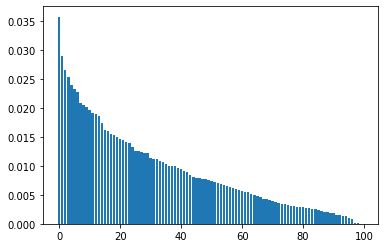

In [49]:
plt.bar(range(100), pca.explained_variance_)

## Visualization using T-SNE

In [50]:
model = TSNE(learning_rate=100, random_state=1, n_jobs=-1, metric='cosine',  verbose=1, init='random')
points2d = model.fit_transform(x_)     

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15954 samples in 0.002s...
[t-SNE] Computed neighbors for 15954 samples in 7.236s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15954
[t-SNE] Computed conditional probabilities for sample 2000 / 15954
[t-SNE] Computed conditional probabilities for sample 3000 / 15954
[t-SNE] Computed conditional probabilities for sample 4000 / 15954
[t-SNE] Computed conditional probabilities for sample 5000 / 15954
[t-SNE] Computed conditional probabilities for sample 6000 / 15954
[t-SNE] Computed conditional probabilities for sample 7000 / 15954
[t-SNE] Computed conditional probabilities for sample 8000 / 15954
[t-SNE] Computed conditional probabilities for sample 9000 / 15954
[t-SNE] Computed conditional probabilities for sample 10000 / 15954
[t-SNE] Computed conditional probabilities for sample 11000 / 15954
[t-SNE] Computed conditional probabilities for sample 12000 / 15954
[t-SNE] Computed conditional probabilities for sam

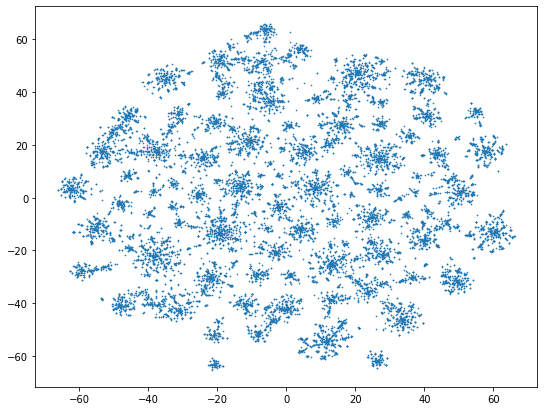

In [51]:
fig = plt.figure(figsize=(9,7))
plot = plt.scatter(points2d[:,0], points2d[:,1], s=0.4)
plt.show()

In [52]:
model3d = TSNE(learning_rate=100, n_components=3, random_state=1, n_jobs=-1, metric='cosine',  verbose=1, init='random')
points3d = model3d.fit_transform(x_)  

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15954 samples in 0.002s...
[t-SNE] Computed neighbors for 15954 samples in 7.174s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15954
[t-SNE] Computed conditional probabilities for sample 2000 / 15954
[t-SNE] Computed conditional probabilities for sample 3000 / 15954
[t-SNE] Computed conditional probabilities for sample 4000 / 15954
[t-SNE] Computed conditional probabilities for sample 5000 / 15954
[t-SNE] Computed conditional probabilities for sample 6000 / 15954
[t-SNE] Computed conditional probabilities for sample 7000 / 15954
[t-SNE] Computed conditional probabilities for sample 8000 / 15954
[t-SNE] Computed conditional probabilities for sample 9000 / 15954
[t-SNE] Computed conditional probabilities for sample 10000 / 15954
[t-SNE] Computed conditional probabilities for sample 11000 / 15954
[t-SNE] Computed conditional probabilities for sample 12000 / 15954
[t-SNE] Computed conditional probabilities for sam

In [53]:
#size = 0.2

#fig = plt.figure(figsize=(9,9))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(points3d[:, 0], points3d[:, 1], points3d[:, 2], s=size)
#plt.show()

In [54]:
def inertia_score(y):
    inertias = []
    for i in range(2, 100):
        kmeans = KMeans(n_clusters=i, random_state=0, n_init="auto").fit(y)
        inertias.append(kmeans.inertia_)
    return inertias

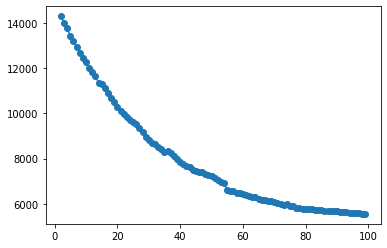

In [55]:
y1 = inertia_score(y)
x = [_ for _ in range(2, len(y1)+2)]
plt.plot(x, y1, '-o')

In [56]:
def silhouette(y):
    scores = []
    for i in range(2, 100):
        kmeans = KMeans(n_clusters=i, random_state=0, n_init="auto").fit(y)
        scores.append(silhouette_score(y, kmeans.labels_))
    return scores

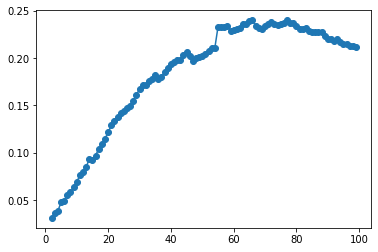

In [57]:
y1 = silhouette(y)
x = [_ for _ in range(2, len(y1)+2)]
plt.plot(x, y1, '-o')

## KMeans

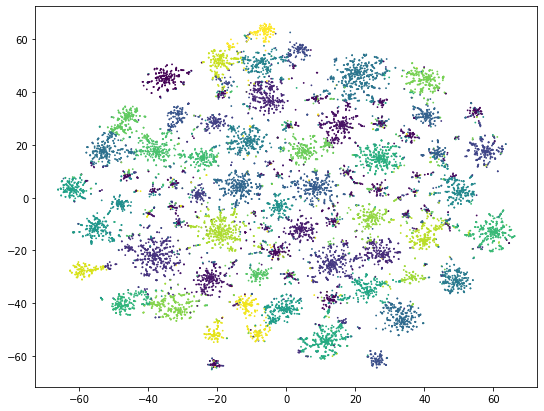

In [58]:
kmeans = KMeans(n_clusters=50, random_state=0, n_init=10).fit(y)
fig = plt.figure(figsize=(9,7))
plot = plt.scatter(points2d[:,0], points2d[:,1], c=kmeans.labels_, s=0.6)
plt.show()

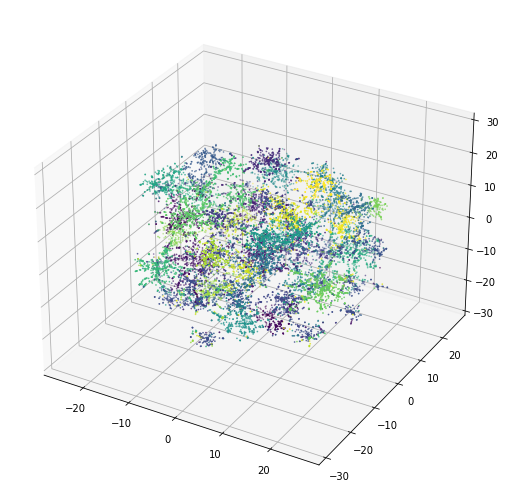

In [59]:
kmeans3d = KMeans(n_clusters=40, random_state=0, n_init=10).fit(y)
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points3d[:, 0], points3d[:, 1], points3d[:,2], c=kmeans3d.labels_, s=0.5)
plt.show()

In [60]:
j = 0
words = []
for i in range(len(y[kmeans.labels_==j])):                    # What is in cluster 0?
    k = nmf.inverse_transform(y[kmeans.labels_==j][i])
    w = vectorizer.get_feature_names_out()[
            sorted(range(len(vectorizer.get_feature_names_out())),
            key=lambda i: k[i], reverse=True)
        ][1:10]
    print(w)
    words.append(w)

['ago' 'old' 'oil' 'engine' 'change' 'font' 'month' 'great' 'bob']
['beauchaine' 'bobbeviceicotekcom' 'bronx' 'manhattan' 'queens' 'sink'
 'stay' 'sea' 'blow']
['beauchaine' 'bobbeviceicotekcom' 'bronx' 'manhattan' 'queens' 'sink'
 'sea' 'stay' 'blow']
['kill' 'bob' 'beauchaine' 'bobbeviceicotekcom' 'bronx' 'manhattan'
 'queens' 'sink' 'stay']
['article' 'objective' 'write' 'bob' 'science' 'right' 'life' 'beauchaine'
 'bobbeviceicotekcom']
['bob' 'beauchaine' 'bobbeviceicotekcom' 'bronx' 'stay' 'manhattan'
 'queens' 'sink' 'sea']
['beauchaine' 'bobbeviceicotekcom' 'bronx' 'manhattan' 'queens' 'sink'
 'stay' 'sea' 'blow']
['ground' 'bob' 'law' 'wire' 'beauchaine' 'bobbeviceicotekcom' 'bronx'
 'manhattan' 'queens']
['write' 'value' 'objective' 'read' 'bob' 'science' 'right' 'mean' 'jim']
['article' 'president' 'bob' 'write' 'bill' 'life' 'beauchaine'
 'bobbeviceicotekcom' 'bronx']
['bob' 'beauchaine' 'bobbeviceicotekcom' 'bronx' 'manhattan' 'queens'
 'believe' 'sink' 'stay']
['bob' 'beau

In [61]:
d = Dictionary(words)
d.filter_extremes()
print(d.most_common())

[('beauchaine', 129), ('bobbeviceicotekcom', 123), ('bronx', 98), ('manhattan', 92), ('queens', 79), ('sink', 71), ('stay', 56), ('sea', 50), ('write', 39), ('life', 34), ('article', 33), ('right', 27), ('team', 27), ('blow', 23), ('year', 22), ('believe', 20), ('problem', 20), ('play', 20), ('hit', 20), ('post', 19), ('hockey', 19), ('baseball', 19), ('win', 19), ('group', 16), ('new', 16), ('espn', 16), ('claim', 15), ('question', 15), ('pitch', 15), ('hell', 14), ('answer', 14), ('email', 14), ('pitcher', 14), ('read', 13), ('religion', 13), ('jesus', 13), ('christ', 12), ('appreciate', 12), ('clinton', 12), ('fbi', 12), ('president', 11), ('christian', 11), ('book', 11), ('ask', 11), ('atheist', 11), ('god', 11), ('ball', 11), ('evidence', 10), ('jews', 10), ('power', 10), ('truth', 10), ('run', 10), ('away', 10), ('player', 10), ('government', 10), ('law', 9), ('bill', 9), ('gun', 9), ('space', 9), ('sale', 9), ('fire', 9), ('oil', 8), ('phone', 8), ('israeli', 8), ('image', 8), (

In [62]:
word = [item for sublist in words for item in sublist]
w = ' '.join(word)
wordcloud = WordCloud().generate(w)

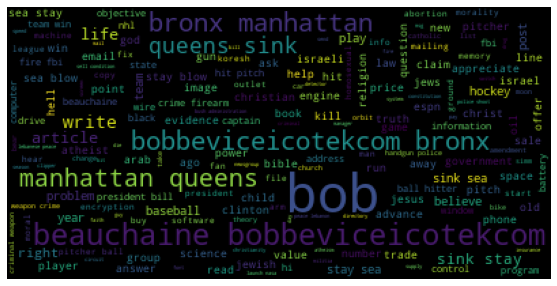

In [63]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## GaussianMixture

In [64]:
from sklearn.mixture import GaussianMixture

In [65]:
gm = GaussianMixture(n_components=45, random_state=0).fit_predict(y)

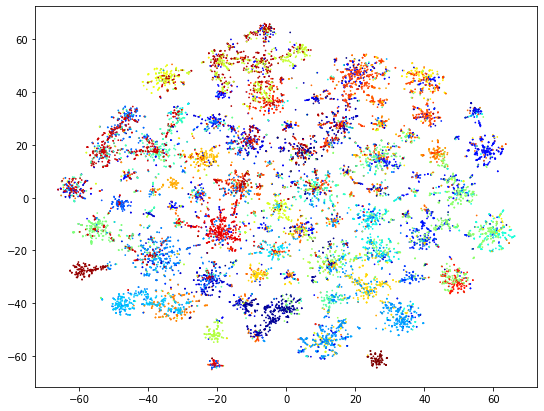

In [66]:
fig = plt.figure(figsize=(9,7))
plot = plt.scatter(points2d[:,0], points2d[:,1], c=gm, s=0.5, cmap='jet')
plt.show()

## Hierarchical clustering 

In [67]:
points2d = np.array([points2d[i] for i in range(len(points2d)) if np.linalg.norm(y[i])>0])
y = np.array([a for a in y if np.linalg.norm(a)>0])
dist_mx = pdist(y, metric='cosine')

In [68]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(dist_mx, method='average')

In [69]:
dist_mx

array([0.27144441, 0.50706323, 0.81106859, ..., 0.94946382, 0.85263103,
       0.84419133])

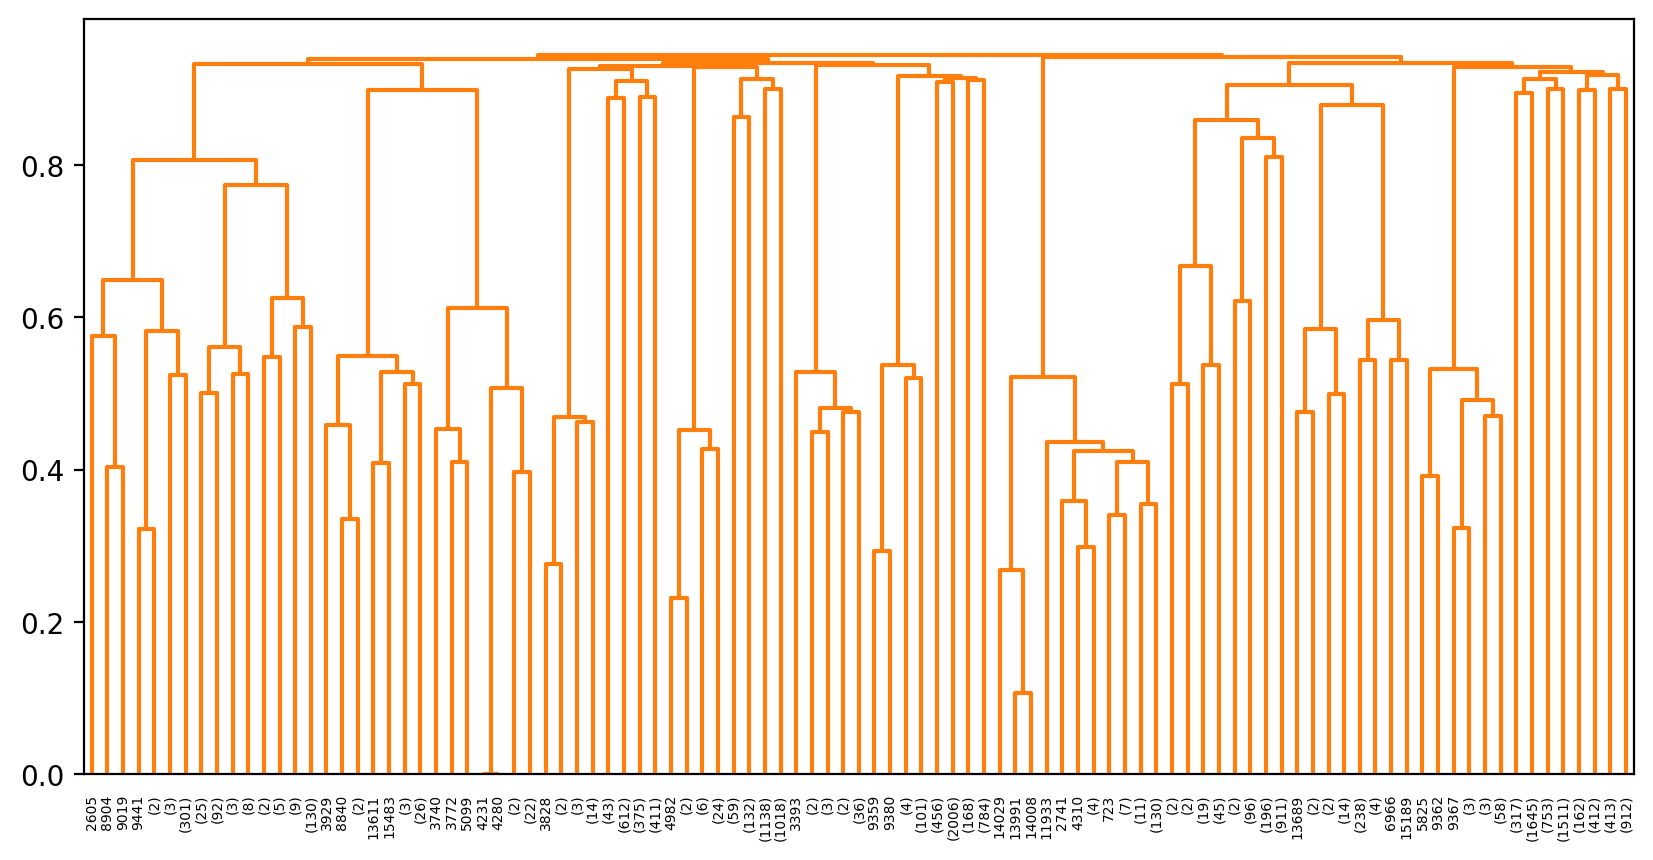

In [70]:
plt.figure(figsize=(10, 5), dpi= 200, facecolor='w', edgecolor='k')
hierarchy.dendrogram(Z, 6, "level", color_threshold=5)
plt.show()

In [77]:
hc = hierarchy.fcluster(Z, 50, 'maxclust')

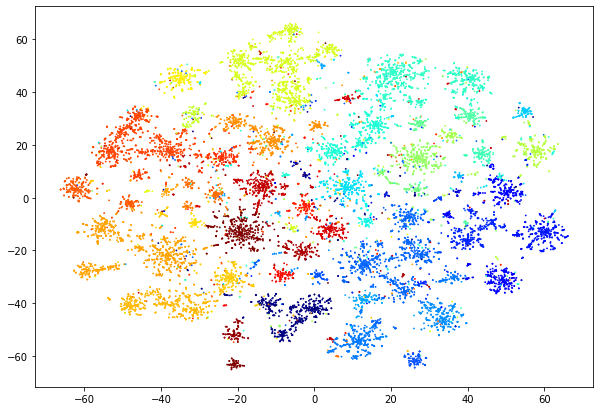

In [78]:
plt.figure(figsize=(10, 7))
plt.scatter(points2d[:,0], points2d[:,1], c=hc, s=0.6, cmap='jet')
plt.show()

In [79]:
j =35
words = []
for i in trange(len(y[hc==j])):                    # what is in claster j?
    k = nmf.inverse_transform(y[hc==j][i])
    w = vectorizer.get_feature_names_out()[
            sorted(range(len(vectorizer.get_feature_names_out())),
            key=lambda i: k[i], reverse=True)
        ][1:10]
    words.append(w)
d = Dictionary(words)
d.filter_extremes()
print(d.most_common()) 

100%|████████████████████████████████████████████████████████████████████████████████| 317/317 [00:09<00:00, 31.71it/s]

[('court', 126), ('law', 97), ('enforcement', 73), ('government', 69), ('right', 65), ('morality', 62), ('gun', 58), ('objective', 58), ('constitution', 55), ('force', 54), ('immoral', 51), ('federal', 49), ('article', 45), ('amendment', 45), ('action', 42), ('arm', 40), ('clinton', 39), ('system', 35), ('society', 30), ('encryption', 30), ('power', 30), ('write', 29), ('claim', 29), ('question', 29), ('militia', 29), ('year', 28), ('bear', 27), ('group', 26), ('book', 25), ('moral', 25), ('crime', 25), ('murder', 24), ('mean', 23), ('god', 22), ('hear', 22), ('post', 21), ('homosexual', 21), ('absolute', 20), ('evidence', 20), ('president', 20), ('problem', 19), ('information', 19), ('weapon', 19), ('man', 19), ('christian', 18), ('bible', 18), ('criminal', 18), ('jesus', 17), ('church', 17), ('christ', 17), ('jews', 16), ('number', 16), ('clipper', 16), ('gay', 16), ('abortion', 15), ('believe', 15), ('phone', 15), ('new', 15), ('kill', 14), ('read', 14), ('sin', 14), ('key', 13), ('

In [87]:
word = [item for sublist in words for item in sublist]
w = ' '.join(word)
wordcloud = WordCloud().generate(w)

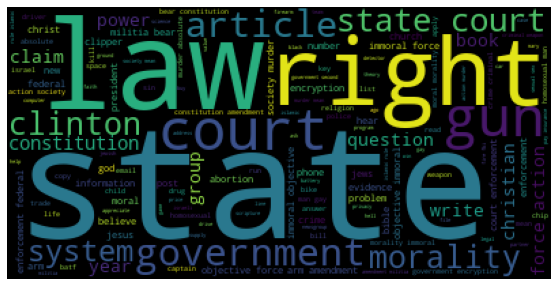

In [88]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Results


In our case, the hierarchical algorithm seems to be the best for this clustering. The cluster sizes appear to be evenly distributed in terms of the number of documents, with some minor noise present.